In [1]:
# !pip install openpyxl
# !pip install imbalanced-learn
# !pip3 install ipympl
# !pip install import-ipynb
# !pip install shapely
# !pip install SciencePlots 
# !pip install seaborn
# !pip install tqdm
# !pip install ipywidgets

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scienceplots
import os, sys
from numpy import nan
import re
import ipympl
# from IPython.core.display import display, HTML
import ipywidgets
import json
from os import listdir
import glob
import math
from IPython.display import Image, display, HTML
from shapely.geometry import mapping
from sklearn.cross_decomposition import PLSRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score, train_test_split, RepeatedKFold, cross_val_predict
from sklearn.metrics import r2_score, mean_squared_error, precision_score, recall_score, mean_absolute_error, make_scorer
from sklearn.svm import SVR
from sklearn.linear_model import LinearRegression
from sklearn.kernel_ridge import KernelRidge
from sklearn.datasets import make_regression
from sklearn.ensemble import GradientBoostingRegressor
from cubist import Cubist
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, LeaveOneOut, cross_validate
from sklearn.impute import SimpleImputer
from tqdm.notebook import tqdm
from sklearn.svm import SVC
from tqdm import tqdm
import pickle
from imblearn.over_sampling import SMOTE
from scipy.stats import ks_2samp
from scipy import stats
np.seterr(divide='ignore', invalid='ignore')
pd.options.display.max_columns = 100
from sklearn.preprocessing import PolynomialFeatures
%matplotlib inline
from scipy.signal import savgol_filter
from scipy.spatial import ConvexHull
from scipy.interpolate import interp1d

In [3]:
import import_ipynb
from SoilPrep import * 

importing Jupyter notebook from SoilPrep.ipynb


# Step 0: Setting up decision paramenters (Data Tree)

In [4]:
# 1. Available smoothing filter types: savgol1 and savgol2 ------------------------ (1)
sg_filters = ['sg1', 'sg2']

# 2. Available window lengths for the smoothing filter ---------------------------- (2)
window_lengths = [0, 1, 11, 21, 31, 41, 51, 61, 71, 81, 91, 101]

# 3. Available preprocessing for Spectral data ------------------------------------ (3)
prepare_spec = ['none', 'fod', 'continuum']
#prepare_spec = ['none', 'fod', 'continuum']

# 4. Number of bands available for resampling spectra ----------------------------- (4) 
nbands_sampling = [0, 5, 10, 20, 30, 40, 50, 100, 200, 500]

# 5. Names of target variables in the dataframe ----------------------------------- (5)
target_names = ['sand', 'silt', 'clay', 'TOC']

# 6. Available preprocessing for Target data -------------------------------------- (6)
prepare_target = ['none', 'minmax']

# 7. Available machine learning regression models --------------------------------- (7)
ml_methods = ['mult', 'plsr', 'randomforest', 'cubist', 'svr', 'ridge', 'gbrt']

# 8. Recorded predictions on test-train data for model accuracy  ------------------ (8)
test_train_predict = ['test', 'testP', 'train', 'trainP']

# Step 1a: Obtaining Spectra (Noise and Outliers removal)

In [5]:
# Colour scheme definition
kado = '#8B7355'
mati = '#A52A2A'
balu = '#F4A460'

In [6]:
df = pd.read_csv('uae.csv')
spectra = df.iloc[:, 7:2158].copy()
temp_spec = spectra.copy()
spectra = temp_spec.iloc[:,150:2051].copy()
spectra.head(5)

,500,501,502,503,504,505,506,507,508,509,510,511,512,513,514,515,516,517,518,519,520,521,522,523,524,525,526,527,528,529,530,531,532,533,534,535,536,537,538,539,540,541,542,543,544,545,546,547,548,549,...,2351,2352,2353,2354,2355,2356,2357,2358,2359,2360,2361,2362,2363,2364,2365,2366,2367,2368,2369,2370,2371,2372,2373,2374,2375,2376,2377,2378,2379,2380,2381,2382,2383,2384,2385,2386,2387,2388,2389,2390,2391,2392,2393,2394,2395,2396,2397,2398,2399,2400
0,0.219696,0.220718,0.221682,0.222762,0.223911,0.225072,0.225983,0.227195,0.228434,0.229447,0.230477,0.231651,0.232982,0.234067,0.235246,0.236547,0.237816,0.238973,0.240065,0.241200,0.242471,0.243782,0.245019,0.246231,0.247492,0.248815,0.250140,0.251416,0.252683,0.253977,0.255289,0.256609,0.257936,0.259318,0.260675,0.262001,0.263489,0.264948,0.266372,0.267808,0.269245,0.270721,0.272237,0.273741,0.275277,0.276850,0.278365,0.279914,0.281544,0.283125,...,0.528987,0.530938,0.532850,0.534835,0.536737,0.538591,0.540523,0.542499,0.544354,0.546408,0.548265,0.549809,0.551226,0.552392,0.553753,0.555323,0.556546,0.557664,0.558510,0.558794,0.559227,0.559746,0.560120,0.560477,0.560730,0.560851,0.560888,0.560840,0.560849,0.560863,0.560784,0.560749,0.560581,0.560264,0.560002,0.559633,0.559214,0.558821,0.558292,0.557767,0.557408,0.557213,0.556984,0.556703,0.556366,0.555859,0.555380,0.555058,0.554763,0.554330
1,0.187783,0.188788,0.189796,0.190691,0.191741,0.192860,0.193714,0.194845,0.195998,0.196942,0.197932,0.199039,0.200258,0.201246,0.202282,0.203435,0.204649,0.205728,0.206735,0.207810,0.209025,0.210258,0.211392,0.212488,0.213674,0.214930,0.216065,0.217232,0.218440,0.219600,0.220764,0.221956,0.223190,0.224454,0.225650,0.226782,0.228110,0.229408,0.230653,0.231906,0.233210,0.234532,0.235775,0.237029,0.238316,0.239613,0.240900,0.242202,0.243545,0.244887,...,0.460117,0.462621,0.465095,0.467602,0.470150,0.472715,0.475381,0.478245,0.480901,0.483715,0.486337,0.488608,0.490808,0.492912,0.494985,0.497080,0.498973,0.500710,0.502163,0.503260,0.504325,0.505288,0.506098,0.506824,0.507423,0.507750,0.508102,0.508479,0.508781,0.509077,0.509369,0.509536,0.509571,0.509527,0.509381,0.509154,0.509002,0.508859,0.508654,0.508430,0.508150,0.507865,0.507586,0.507207,0.506834,0.506487,0.506097,0.505641,0.505250,0.504820
2,0.165603,0.166606,0.167606,0.168545,0.169584,0.170685,0.171606,0.172728,0.173862,0.174827,0.175771,0.176913,0.178225,0.179122,0.180132,0.181309,0.182467,0.183550,0.184579,0.185635,0.186868,0.188132,0.189288,0.190384,0.191511,0.192711,0.193982,0.195140,0.196240,0.197401,0.198585,0.199772,0.200951,0.202163,0.203339,0.204486,0.205816,0.207072,0.208248,0.209476,0.210717,0.211974,0.213223,0.214438,0.215646,0.216856,0.218078,0.219319,0.220595,0.221881,...,0.293886,0.295451,0.297061,0.298779,0.300473,0.302255,0.303971,0.305683,0.307329,0.309024,0.310630,0.312102,0.313447,0.314723,0.315887,0.316964,0.317921,0.318633,0.319301,0.319886,0.320333,0.320726,0.320994,0.321101,0.321141,0.320984,0.320895,0.320859,0.320782,0.320510,0.320220,0.319724,0.319154,0.318653,0.318137,0.317584,0.316948,0.316324,0.315672,0.314978,0.314146,0.313320,0.312549,0.311700,0.310928,0.310244,0.309595,0.308888,0.308181,0.307299
3,0.258894,0.260033,0.261232,0.262371,0.263599,0.264844,0.265754,0.267021,0.268392,0.269578,0.270728,0.271973,0.273376,0.274612,0.275852,0.277160,0.278517,0.279843,0.281097,0.282317,0.283717,0.285161,0.286502,0.287831,0.289182,0.290585,0.292071,0.293412,0.294704,0.296116,0.297506,0.298905,0.300361,0.301824,0.303245,0.304631,0.306135,0.307635,0.309125,0.310584,0.312084,0.313623,0.315119,0.316595,0.318116,0.319678,0.321119,0.322629,0.324289,0.325896,...,0.488263,0.490756,0.493272,0.495855,0.498441,0.501130,0.503797,0.506493,0.509112,0.511922,0.514517,0.516820,0.519022,0.521089,0.523098,0.525139,0.526950,0.528498,0.529838,0.530912,0.531866,0.532648,0.533371,0.533968,0.534490,0.534928,0.535253,0.535459,0.535783,0.535840,0.535877,0.535990,0.535914,0.535973,0.536102,0.535930,0.535746,0.535411,0.534900,0.534548,0.534110,0.

In [7]:
# for i in range (0,5,1):
#     spectra.iloc[i,:].plot()

# Step 1b: Obtaining Targets (Outliers removal and Normalization)

In [8]:
df = pd.read_csv('uae.csv')
# ------------- Target Isolation ----------------------

clr = ['#F4A460', '#8B7355', '#A52A2A', 'green']

def isolate_targets(df, target_names):
    T=[]
    for i in range (0,len(target_names)):
        T.append(df[target_names[i]])
    return(T)
    
T = isolate_targets(df,target_names) 


def normalize_targets(T):          
    NT =[]
    for i in range(0, len(T)):
        NT.append(min_max_normal(T[i].copy()))
    return(NT)

NT = normalize_targets(T)


# Step 1c: Spectra Preprocessing (Smooth, FOD/Contin, and Resample)

## Savgol smoothing (order 1 and order 2)

In [9]:
# -------------- Smoothed Spectra spec1 (savgol order 1) and spec2 (savgol order 2)  -----------

spec1 = {}
for i in window_lengths:
    spec1[i] = filt_sg(spectra, i, 'sg1')                   

spec2 = {}
for i in window_lengths:
    spec2[i] = filt_sg(spectra, i, 'sg2')

smth_spec = sgsmooth (spectra, 3)    

## First Order Derivative

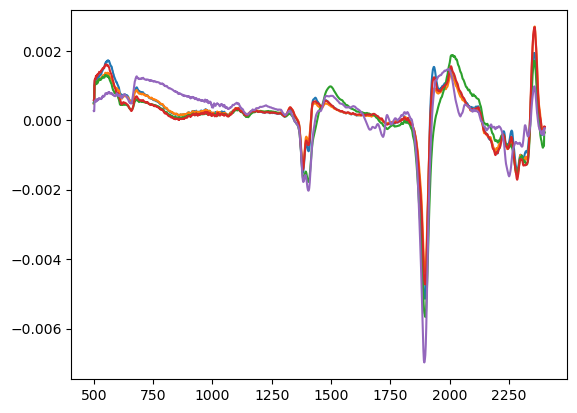

In [10]:
fod_spec = fod(smth_spec)

for i in range (0,5,1):
    fod_spec.iloc[i,:].plot()


## Continuum Removal

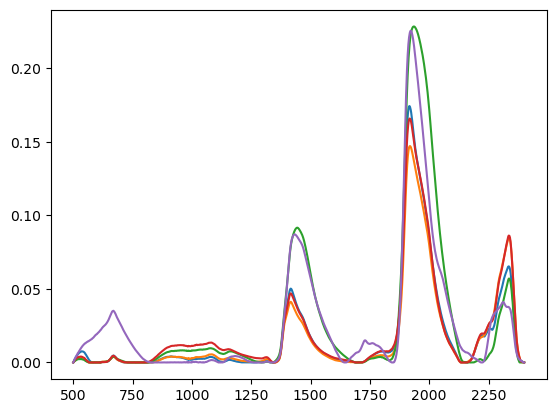

In [11]:
cr_spec = continuum_removed(spec2[51])

for i in range (0,5,1):
    cr_spec.iloc[i,:].plot()
    

## Resampling (n_bands)

### 1. Sampled Original (sampled_spec: sampled clipped_spectra)

In [12]:
sampled_spec = {}
for n in nbands_sampling:
    sampled_spec[n] = resample_spectra (spec2[51], n)

In [13]:
# for i in range (0,5,1):
#     sampled_spec[200].iloc[i,:].plot()

### 2. Sampled Continuum Removed  (sampled_cr)

In [14]:
sampled_cr = {}
for n in nbands_sampling:
    sampled_cr[n] = resample_spectra (cr_spec, n)

In [15]:
# for i in range (0,5,1):
#     sampled_cr[200].iloc[i,:].plot()

### 3. Sampled FOD  (sampled_fod)

In [16]:
sampled_fod = {}
for n in nbands_sampling:
    sampled_fod[n] = resample_spectra (fod_spec, n)

In [17]:
# for i in range (0,10,1):
#     sampled_fod[200].iloc[i,:].plot()

## Visualizing Processed Spectrum (variable samples)

In [18]:
def plot_spec (sample, process):
    x1 = spec2[51].iloc[sample,:]
    x1.plot()
    if process == 'continuum':
        x2 = cr_spec.iloc[sample,:]
        x2.plot()
    else: 
        x3 = fod_spec.iloc[sample,:]*100
        
        x3.plot()
    plt.ylim([-0.6, 0.8])

ipywidgets.interact(plot_spec, sample = (0, 293,1), process = ['fod', 'continuum'])

interactive(children=(IntSlider(value=146, description='sample', max=293), Dropdown(description='process', opt…

<function __main__.plot_spec(sample, process)>

## Correlation between wavelengths and Targets

In [19]:
plt.style.use(['science','notebook','grid'])

def plot_corr (target, spec_cr_fod, n_bands):
    
    i = target_names.index(target)    
    
    if  spec_cr_fod == 'spec':
        r_val, p_val = find_rpval (resample_spectra(spec2[51], n_bands), T[i])
        r_val.iloc[0,:].plot(color = clr[i])
    elif  spec_cr_fod == 'cr':
        r_cr, p_cr = find_rpval (resample_spectra(cr_spec, n_bands), T[i])
        r_cr.iloc[0,:].plot(color = clr[i])
    else:
        r_fod, p_fod = find_rpval (resample_spectra(fod_spec, n_bands), T[i])
        r_fod.iloc[0,:].plot(color = clr[i])
    
    plt.ylim([-0.7, 0.7])

ipywidgets.interact(plot_corr, target = target_names, spec_cr_fod = ['spec', 'cr','fod'], n_bands = nbands_sampling)



interactive(children=(Dropdown(description='target', options=('sand', 'silt', 'clay', 'TOC'), value='sand'), D…

<function __main__.plot_corr(target, spec_cr_fod, n_bands)>

# Step 2:  Parameters for Best Train-Test Split  

In [20]:
# Building Mtree (Model Tree) ----------------------------------

tst_siz = 0.20

rand_t = [None] * (len(T))
err_t = [None] * (len(T))

print('Without Normalization:')
for i in range (0,len(T)):
    rand_t[i], err_t[i] = best_split(spectra.copy(), T[i], tst_siz) 
    print ('For '+ target_names[i]+ ' :test size =', tst_siz, '\t min bin error=', err_t[i], '\t at randome state =', rand_t[i])
    
rand_nt = [None] * (len(T))
err_nt = [None] * (len(T))

print('After Normalization:')
for i in range (0,len(T)):
    rand_nt[i], err_nt[i] = best_split(spectra.copy(), NT[i], tst_siz)     
    print ('For '+ target_names[i]+ ' :test size =', tst_siz, '\t min bin error=', err_nt[i], '\t at randome state =', rand_nt[i])
    
    

Without Normalization:
For sand :test size = 0.2 	 min bin error= 21.25 	 at randome state = 18
For silt :test size = 0.2 	 min bin error= 18.75 	 at randome state = 13
For clay :test size = 0.2 	 min bin error= 31.25 	 at randome state = 7
For TOC :test size = 0.2 	 min bin error= 13.75 	 at randome state = 15
After Normalization:
For sand :test size = 0.2 	 min bin error= 33.75 	 at randome state = 23
For silt :test size = 0.2 	 min bin error= 33.75 	 at randome state = 0
For clay :test size = 0.2 	 min bin error= 31.25 	 at randome state = 7
For TOC :test size = 0.2 	 min bin error= 23.75 	 at randome state = 13


# Step 3: Parameters for Best Model Fit 

## PLSR

In [21]:
from sklearn import linear_model

def best_param_PLSR (X_train, X_test, y_train, y_test, n_comp):
        
    iqrpL = []
#     r2L = []
#     rpdL = []
    
    for n in range(1,n_comp):
        Model = PLSRegression(n_components=n, scale=True)
        Model.fit(X_train, y_train)
        y_pred = Model.predict(X_test, copy=True)
        
        iqrp_test = find_iqrp(y_pred, y_test)
#         r2_test = find_r2(y_pred, y_test)         
#         rpd_test = find_rpd(y_pred, y_test)
               
        iqrpL.append(iqrp_test)
#         r2L.append(r2_test)
#         rpdL.append(rpd_test)
                
    
    IQRP = max(iqrpL)
    n_iqrp = iqrpL.index(max(iqrpL))+1
#     R2 = max(r2L)     
#     n_r2 = r2L.index(R2)+1    
#     RPD = max(rpdL)
#     n_rpd = rpdL.index(RPD)+1
    
    #print('IQRP :', IQRP,  'R2 :', R2,  '>>> n_comp: ', n_iqrp)    
    return (n_iqrp)
        
 

# Step 4: Building Model Tree (Mtree)

In [22]:
import os
os.system('say "your program has finished"')
import time

In [43]:
# 0. Available machine learning regression models --------------------------------- (7)
ml_methods = ['mult', 'plsr', 'randomforest', 'cubist', 'svr', 'ridge', 'gbrt']
#ml_methods = ['mult', 'plsr', 'cubist', 'randomforest', 'ridge' 'gbrt', 'svr']

In [24]:
max_n_comp = 5

def build_tree_for (method_name):
    tree ={}
    start = time.time()
    m = method_name
    #-- code to build tree----
    for t in target_names:
        print('tree for: '+ m +' ------> running on: ' + t)
        tree[t] ={}
        for tp in prepare_target:
            tree[t][tp] ={}
            for n in nbands_sampling:
                tree[t][tp][n] ={}
                for p in prepare_spec:
                    tree[t][tp][n][p] ={}
                    Y = tree[t][tp][n][p]
                    
                        
                    #------ setting spec to appropriate (sampled) spectra----
                    if p == 'none':
                        if n == 0:
                            if m == 'randomforest' or m == 'cubist' or m == 'gbrt':
                                #---- reched here due to tree based methods e.g. randomforest--
                                spec = sampled_spec[100]
                            else:
                                spec = spec2[51]
                        else:
                            #---- reached here with some n!=0----
                            spec = sampled_spec[n]
                        
                    elif p == 'fod':
                        if n == 0:
                            if m == 'randomforest' or m == 'cubist' or m == 'gbrt':
                                #---- reched here due to tree based methods e.g. randomforest--
                                spec = sampled_fod[100]
                            else:
                                spec = fod_spec
                        else:
                            #---- reached here with some n!=0----
                            spec = sampled_fod[n]
                                
                    else:  
                        if n == 0:
                            if m == 'randomforest' or m == 'cubist' or m == 'gbrt':
                                #---- reched here due to tree based methods e.g. randomforest--
                                spec = sampled_cr[100]
                            else:
                                spec = cr_spec
                        else:
                            #---- reached here with some n!=0----
                            spec = sampled_cr[n]
                        
                    #---- target selection and normalization ---
                    if tp == 'none':
                        y = T[target_names.index(t)]
                        rand_n = rand_t[target_names.index(t)]  #-- for future use in train-test split
                    else:
                        y = NT[target_names.index(t)]
                        rand_n = rand_nt[target_names.index(t)] #-- for future use in train-test split
                        #print('one more target set')
                            
                    #---- performing train-test split----------------------
                    X_train, X_test, y_train, y_test = train_test_split(spec, y, test_size= tst_siz, random_state=rand_n)
                        
                        
                    #------INITIATING the appropriate models-----------------------------------------------
                    #----- PLSR: best parameters, fitting, and prediction
                    if m == 'plsr':
                        n_com = best_param_PLSR (X_train, X_test, y_train, y_test, max_n_comp)
                        Y['n_comp'] = n_com
                        Model = PLSRegression(n_components=n_com, scale=True)
                    #----- MULTILINEAR:  fitting, and prediction---------- 
                    elif m == 'mult':
                        Model = linear_model.LinearRegression()    
                    #----- RANDOM_FOREST:   fitting, and prediction---------- 
                    elif m == 'randomforest': 
                        Model = RandomForestRegressor(random_state= 23)    
                    #----- CUBIST REGRESSION:    fitting and prediction---------
                    elif m == 'cubist':
                        Model = Cubist(n_rules = 50, n_committees = 5, random_state = 42)    
                    #------ SUPPORT VECTOR MACHINE FOR REGRESSION: fitting and prediction-----------      
                    elif m == 'svr': 
                        Model = SVR()
                    #------ RIDGE REGRESSION: fitting and prediction-----------      
                    elif m == 'ridge': 
                        Model = KernelRidge()
                    #------ GRADIENT BOOSTING REGRESSION: fitting and prediction-----------      
                    else: 
                        Model = GradientBoostingRegressor()                         
                        
                    Model.fit(X_train, y_train)
                    y_pred = Model.predict(X_test)
                    yhat_pred = Model.predict(X_train)
                                
                    Y['test'] = y_test
                    Y['testP'] = y_pred
                    Y['train'] = y_train
                    Y['trainP'] = yhat_pred
                    Y['iqrp_test'] = find_iqrp(y_pred, y_test)
                    Y['r2_test'] = find_r2(y_pred, y_test)
                    Y['rpd_test'] = find_rpd(y_pred, y_test)
                    Y['rmse_test'] = find_rmse(y_pred, y_test)
                                                                
                                                                         
    end = time.time()                            
    os.system('say "your program has finished"')                            

    print('End time - Start time =', (end-start)) 
    
    return (tree.copy())


## Mtree initialisation (do not run below code every time)

In [25]:
Mtree ={}

## Creating different branches of Mtree (for separate methods)

### PLSR Branch 

In [26]:
Mtree['plsr'] = build_tree_for ('plsr')

tree for: plsr ------> running on: sand
tree for: plsr ------> running on: silt
tree for: plsr ------> running on: clay
tree for: plsr ------> running on: TOC
End time - Start time = 13.60158896446228


### Multiple Linear Regression Branch

In [27]:
Mtree['mult'] = build_tree_for ('mult')

tree for: mult ------> running on: sand
tree for: mult ------> running on: silt
tree for: mult ------> running on: clay
tree for: mult ------> running on: TOC
End time - Start time = 4.455110311508179



### Random Forest Branch

In [28]:
Mtree['randomforest'] = build_tree_for ('randomforest')

tree for: randomforest ------> running on: sand
tree for: randomforest ------> running on: silt
tree for: randomforest ------> running on: clay
tree for: randomforest ------> running on: TOC
End time - Start time = 456.37540650367737


### SVM Branch

In [29]:
Mtree['svr'] = build_tree_for ('svr')

tree for: svr ------> running on: sand
tree for: svr ------> running on: silt
tree for: svr ------> running on: clay
tree for: svr ------> running on: TOC
End time - Start time = 8.273990154266357


### GBRT Branch

In [30]:
Mtree['gbrt'] = build_tree_for ('gbrt')

tree for: gbrt ------> running on: sand
tree for: gbrt ------> running on: silt
tree for: gbrt ------> running on: clay
tree for: gbrt ------> running on: TOC
End time - Start time = 277.39433670043945


### Ridge Regression Branch

In [31]:
Mtree['ridge'] = build_tree_for ('ridge')

tree for: ridge ------> running on: sand
tree for: ridge ------> running on: silt
tree for: ridge ------> running on: clay
tree for: ridge ------> running on: TOC
End time - Start time = 2.9752984046936035


### Cubist Branch

In [42]:
Mtree['cubist'] = build_tree_for ('cubist')

tree for: cubist ------> running on: sand


C:\Users\abhis\anaconda3\envs\RP_Env\lib\site-packages\cubist\_quinlan_attributes.py:67: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  return {col_name: _get_data_format(col_data) for col_name, col_data in df.iteritems()}
C:\Users\abhis\anaconda3\envs\RP_Env\lib\site-packages\cubist\_quinlan_attributes.py:67: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  return {col_name: _get_data_format(col_data) for col_name, col_data in df.iteritems()}
C:\Users\abhis\anaconda3\envs\RP_Env\lib\site-packages\cubist\_quinlan_attributes.py:67: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  return {col_name: _get_data_format(col_data) for col_name, col_data in df.iteritems()}
C:\Users\abhis\anaconda3\envs\RP_Env\lib\site-packages\cubist\_quinlan_attributes.py:67: FutureWarning: iteritems is deprecated and will be removed in a future versio

C:\Users\abhis\anaconda3\envs\RP_Env\lib\site-packages\cubist\_quinlan_attributes.py:67: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  return {col_name: _get_data_format(col_data) for col_name, col_data in df.iteritems()}
C:\Users\abhis\anaconda3\envs\RP_Env\lib\site-packages\cubist\_quinlan_attributes.py:67: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  return {col_name: _get_data_format(col_data) for col_name, col_data in df.iteritems()}
C:\Users\abhis\anaconda3\envs\RP_Env\lib\site-packages\cubist\_quinlan_attributes.py:67: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  return {col_name: _get_data_format(col_data) for col_name, col_data in df.iteritems()}
C:\Users\abhis\anaconda3\envs\RP_Env\lib\site-packages\cubist\_quinlan_attributes.py:67: FutureWarning: iteritems is deprecated and will be removed in a future versio

tree for: cubist ------> running on: silt


C:\Users\abhis\anaconda3\envs\RP_Env\lib\site-packages\cubist\_quinlan_attributes.py:67: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  return {col_name: _get_data_format(col_data) for col_name, col_data in df.iteritems()}
C:\Users\abhis\anaconda3\envs\RP_Env\lib\site-packages\cubist\_quinlan_attributes.py:67: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  return {col_name: _get_data_format(col_data) for col_name, col_data in df.iteritems()}
C:\Users\abhis\anaconda3\envs\RP_Env\lib\site-packages\cubist\_quinlan_attributes.py:67: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  return {col_name: _get_data_format(col_data) for col_name, col_data in df.iteritems()}
C:\Users\abhis\anaconda3\envs\RP_Env\lib\site-packages\cubist\_quinlan_attributes.py:67: FutureWarning: iteritems is deprecated and will be removed in a future versio

C:\Users\abhis\anaconda3\envs\RP_Env\lib\site-packages\cubist\_quinlan_attributes.py:67: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  return {col_name: _get_data_format(col_data) for col_name, col_data in df.iteritems()}
C:\Users\abhis\anaconda3\envs\RP_Env\lib\site-packages\cubist\_quinlan_attributes.py:67: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  return {col_name: _get_data_format(col_data) for col_name, col_data in df.iteritems()}
C:\Users\abhis\anaconda3\envs\RP_Env\lib\site-packages\cubist\_quinlan_attributes.py:67: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  return {col_name: _get_data_format(col_data) for col_name, col_data in df.iteritems()}
C:\Users\abhis\anaconda3\envs\RP_Env\lib\site-packages\cubist\_quinlan_attributes.py:67: FutureWarning: iteritems is deprecated and will be removed in a future versio

tree for: cubist ------> running on: clay


C:\Users\abhis\anaconda3\envs\RP_Env\lib\site-packages\cubist\_quinlan_attributes.py:67: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  return {col_name: _get_data_format(col_data) for col_name, col_data in df.iteritems()}
C:\Users\abhis\anaconda3\envs\RP_Env\lib\site-packages\cubist\_quinlan_attributes.py:67: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  return {col_name: _get_data_format(col_data) for col_name, col_data in df.iteritems()}
C:\Users\abhis\anaconda3\envs\RP_Env\lib\site-packages\cubist\_quinlan_attributes.py:67: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  return {col_name: _get_data_format(col_data) for col_name, col_data in df.iteritems()}
C:\Users\abhis\anaconda3\envs\RP_Env\lib\site-packages\cubist\_quinlan_attributes.py:67: FutureWarning: iteritems is deprecated and will be removed in a future versio

C:\Users\abhis\anaconda3\envs\RP_Env\lib\site-packages\cubist\_quinlan_attributes.py:67: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  return {col_name: _get_data_format(col_data) for col_name, col_data in df.iteritems()}
C:\Users\abhis\anaconda3\envs\RP_Env\lib\site-packages\cubist\_quinlan_attributes.py:67: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  return {col_name: _get_data_format(col_data) for col_name, col_data in df.iteritems()}
C:\Users\abhis\anaconda3\envs\RP_Env\lib\site-packages\cubist\_quinlan_attributes.py:67: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  return {col_name: _get_data_format(col_data) for col_name, col_data in df.iteritems()}
C:\Users\abhis\anaconda3\envs\RP_Env\lib\site-packages\cubist\_quinlan_attributes.py:67: FutureWarning: iteritems is deprecated and will be removed in a future versio

tree for: cubist ------> running on: TOC


C:\Users\abhis\anaconda3\envs\RP_Env\lib\site-packages\cubist\_quinlan_attributes.py:67: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  return {col_name: _get_data_format(col_data) for col_name, col_data in df.iteritems()}
C:\Users\abhis\anaconda3\envs\RP_Env\lib\site-packages\cubist\_quinlan_attributes.py:67: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  return {col_name: _get_data_format(col_data) for col_name, col_data in df.iteritems()}
C:\Users\abhis\anaconda3\envs\RP_Env\lib\site-packages\cubist\_quinlan_attributes.py:67: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  return {col_name: _get_data_format(col_data) for col_name, col_data in df.iteritems()}
C:\Users\abhis\anaconda3\envs\RP_Env\lib\site-packages\cubist\_quinlan_attributes.py:67: FutureWarning: iteritems is deprecated and will be removed in a future versio

C:\Users\abhis\anaconda3\envs\RP_Env\lib\site-packages\cubist\_quinlan_attributes.py:67: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  return {col_name: _get_data_format(col_data) for col_name, col_data in df.iteritems()}
C:\Users\abhis\anaconda3\envs\RP_Env\lib\site-packages\cubist\_quinlan_attributes.py:67: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  return {col_name: _get_data_format(col_data) for col_name, col_data in df.iteritems()}
C:\Users\abhis\anaconda3\envs\RP_Env\lib\site-packages\cubist\_quinlan_attributes.py:67: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  return {col_name: _get_data_format(col_data) for col_name, col_data in df.iteritems()}
C:\Users\abhis\anaconda3\envs\RP_Env\lib\site-packages\cubist\_quinlan_attributes.py:67: FutureWarning: iteritems is deprecated and will be removed in a future versio

End time - Start time = 163.48865175247192


## Best of all worlds

In [44]:
#ml_methods = ['mult', 'plsr', 'randomforest','svr', 'ridge', 'gbrt']

In [45]:
def best_model_parameters (Mtree, target, method, scorer):
    t=target
    m= method
    
    best_score = -1
    best_n_comp = 'NA'
    
    
    for tp in prepare_target:
        for n in nbands_sampling:
            for p in prepare_spec:
                Y = Mtree[m][t][tp][n][p]
                    
                if scorer == 'iqrp':
                    cur_score = Y['iqrp_test']
                elif scorer == 'rpd':
                    cur_score = Y['rpd_test']
                else:
                    cur_score = Y['r2_test']  
                    
                if cur_score > best_score:
                    best_score = cur_score
                    best_tp = tp
                    best_n = n
                    best_p = p
                    if m == 'plsr':
                        best_n_comp = Y['n_comp']
                            
    param_list = [scorer, np.round(best_score,2), 'Spec:', best_p, 'bands:', best_n, 'Tar:', best_tp]                                 
    return (param_list)                                
    

In [46]:
def best_score_for (Mtree, target, scorer):
    
    for method in ml_methods:
        param_list= best_model_parameters (Mtree, target, method, scorer)
        print('For:'+target+'->', param_list, ':'+method)
     
    return

In [48]:
best_score_for(Mtree, 'sand', 'iqrp')

For:sand-> ['iqrp', 2.08, 'Spec:', 'none', 'bands:', 50, 'Tar:', 'minmax'] :mult
For:sand-> ['iqrp', 2.22, 'Spec:', 'continuum', 'bands:', 200, 'Tar:', 'minmax'] :plsr
For:sand-> ['iqrp', 1.93, 'Spec:', 'continuum', 'bands:', 50, 'Tar:', 'minmax'] :randomforest
For:sand-> ['iqrp', 2.16, 'Spec:', 'continuum', 'bands:', 0, 'Tar:', 'minmax'] :cubist
For:sand-> ['iqrp', 1.7, 'Spec:', 'fod', 'bands:', 500, 'Tar:', 'minmax'] :svr
For:sand-> ['iqrp', 1.71, 'Spec:', 'none', 'bands:', 0, 'Tar:', 'minmax'] :ridge
For:sand-> ['iqrp', 2.01, 'Spec:', 'fod', 'bands:', 500, 'Tar:', 'minmax'] :gbrt


In [49]:
best_score_for(Mtree, 'sand', 'r2')

For:sand-> ['r2', 0.58, 'Spec:', 'none', 'bands:', 50, 'Tar:', 'minmax'] :mult
For:sand-> ['r2', 0.63, 'Spec:', 'continuum', 'bands:', 200, 'Tar:', 'minmax'] :plsr
For:sand-> ['r2', 0.51, 'Spec:', 'continuum', 'bands:', 50, 'Tar:', 'minmax'] :randomforest
For:sand-> ['r2', 0.61, 'Spec:', 'continuum', 'bands:', 0, 'Tar:', 'minmax'] :cubist
For:sand-> ['r2', 0.37, 'Spec:', 'fod', 'bands:', 500, 'Tar:', 'minmax'] :svr
For:sand-> ['r2', 0.38, 'Spec:', 'none', 'bands:', 0, 'Tar:', 'minmax'] :ridge
For:sand-> ['r2', 0.55, 'Spec:', 'fod', 'bands:', 500, 'Tar:', 'minmax'] :gbrt


In [50]:
best_score_for(Mtree, 'TOC', 'iqrp')

For:TOC-> ['iqrp', 1.75, 'Spec:', 'continuum', 'bands:', 10, 'Tar:', 'none'] :mult
For:TOC-> ['iqrp', 1.9, 'Spec:', 'continuum', 'bands:', 200, 'Tar:', 'none'] :plsr
For:TOC-> ['iqrp', 1.83, 'Spec:', 'continuum', 'bands:', 500, 'Tar:', 'none'] :randomforest
For:TOC-> ['iqrp', 1.91, 'Spec:', 'continuum', 'bands:', 10, 'Tar:', 'none'] :cubist
For:TOC-> ['iqrp', 1.83, 'Spec:', 'fod', 'bands:', 0, 'Tar:', 'none'] :svr
For:TOC-> ['iqrp', 1.62, 'Spec:', 'continuum', 'bands:', 0, 'Tar:', 'none'] :ridge
For:TOC-> ['iqrp', 1.79, 'Spec:', 'continuum', 'bands:', 200, 'Tar:', 'none'] :gbrt


In [51]:
best_score_for(Mtree, 'TOC', 'r2')

For:TOC-> ['r2', 0.5, 'Spec:', 'continuum', 'bands:', 10, 'Tar:', 'none'] :mult
For:TOC-> ['r2', 0.57, 'Spec:', 'continuum', 'bands:', 200, 'Tar:', 'none'] :plsr
For:TOC-> ['r2', 0.54, 'Spec:', 'continuum', 'bands:', 500, 'Tar:', 'none'] :randomforest
For:TOC-> ['r2', 0.58, 'Spec:', 'continuum', 'bands:', 10, 'Tar:', 'none'] :cubist
For:TOC-> ['r2', 0.54, 'Spec:', 'fod', 'bands:', 0, 'Tar:', 'none'] :svr
For:TOC-> ['r2', 0.42, 'Spec:', 'continuum', 'bands:', 0, 'Tar:', 'none'] :ridge
For:TOC-> ['r2', 0.52, 'Spec:', 'continuum', 'bands:', 200, 'Tar:', 'none'] :gbrt


## Plotting Model Accuracy (ipywidgets)

In [40]:
def plot_model_acc (target, target_preprocessing, spec_preprocessing, n_bands, method):
    
    m = method
    t = target
    
    i = target_names.index(target)
    
    
    p = spec_preprocessing
    n = n_bands
    tp = target_preprocessing
    
    Y = Mtree[m][t][tp][n][p]
    
    y_test = Y['test']
    y_pred = Y['testP']
    y_train = Y['train']
    yhat_pred = Y['trainP']
    
    if m == 'plsr':
        n_com = Y['n_comp']
        y_pred = y_pred[:,0]
        yhat_pred = yhat_pred[:,0]
    
    
    iqrp_test = Y['iqrp_test']
    r2_test = Y['r2_test']
    rpd_test = Y['rpd_test']
    
    iqrp_train = find_iqrp(yhat_pred, y_train)
    r2_train = find_r2(yhat_pred, y_train)
    rpd_train = find_rpd(yhat_pred, y_train)
    
    y_tp = pd.DataFrame({'actual':y_test.values, 'predic': y_pred})
    z = np.polyfit(y_test, y_pred, 1)
    
    yhat_tp = pd.DataFrame({'actual':y_train.values, 'predic': yhat_pred})
    zhat = np.polyfit(y_train, yhat_pred, 1)
    
    fig, axes = plt.subplots(1,2, figsize=(18,8))
    
    #with plt.style.context(('ggplot')): ---- PLOT of test-prediction --------------------------------------
    y_tp.plot.scatter(ax= axes[0], x="actual", y="predic", alpha=0.8, color = clr[i], edgecolors='k')
    axes[0].plot(y_test, np.polyval(z, y_test),  c='blue', linewidth=1)
    axes[0].plot(y_test, y_test, color='green', linewidth=1)
    axes[0].tick_params(axis='both', labelsize=10)
    axes[0].text(0.05, 0.95, target_names[i]+' (Test Data)', transform=axes[0].transAxes, fontsize = 20, color = clr[i])
    axes[0].text(0.05, 0.90, 'IQRP ={:.2f}'.format(iqrp_test), transform=axes[0].transAxes, fontsize = 16)
    axes[0].text(0.05, 0.85, 'RPD ={:.2f}'.format(rpd_test), transform=axes[0].transAxes, fontsize = 16)
    axes[0].text(0.05, 0.80, 'R2 ={:.2f}'.format(np.round(r2_test,3)), transform=axes[0].transAxes, fontsize = 16)
    axes[0].text(0.95, 0.15, 'Method: '+method, transform=axes[0].transAxes, 
                    horizontalalignment='right', fontsize = 20)
    
    if method == 'plsr':
        axes[0].text(0.95, 0.05, 'n_component={:.2f}'.format(n_com), transform=axes[0].transAxes, 
                    horizontalalignment='right', fontsize = 12)
    
    #---------------------------------- ---- PLOT of train-prediction --------------------------------------
    yhat_tp.plot.scatter(ax= axes[1], x="actual", y="predic", alpha=0.8, color = clr[i], edgecolors='k')
    axes[1].plot(y_train, np.polyval(zhat, y_train),  c='blue', linewidth=1)
    axes[1].plot(y_train, y_train, color='green', linewidth=1)
    axes[1].tick_params(axis='both', labelsize=10)
    axes[1].text(0.05, 0.95,  target_names[i]+' (Training Data)', transform=axes[1].transAxes,fontsize = 20, color = clr[i])
    axes[1].text(0.05, 0.90, 'IQRP ={:.2f}'.format(iqrp_train), transform=axes[1].transAxes, fontsize = 16)
    axes[1].text(0.05, 0.85, 'RPD ={:.2f}'.format(rpd_train), transform=axes[1].transAxes, fontsize = 16)
    axes[1].text(0.05, 0.80, 'R2 ={:.2f}'.format(np.round(r2_train,3)), transform=axes[1].transAxes, fontsize = 16)
    axes[1].text(0.95, 0.15, 'Method: '+method, transform=axes[1].transAxes, 
                    horizontalalignment='right', fontsize = 20)
    return    

In [41]:
ipywidgets.interact(plot_model_acc, target = target_names,target_preprocessing = prepare_target, \
                    method = ml_methods, spec_preprocessing = prepare_spec, n_bands = nbands_sampling)

interactive(children=(Dropdown(description='target', options=('sand', 'silt', 'clay', 'TOC'), value='sand'), D…

<function __main__.plot_model_acc(target, target_preprocessing, spec_preprocessing, n_bands, method)>